Conda env: `aops_tenflow`

In [1]:
import os
import shutil
from time import perf_counter

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.util import create_folder
from utils.util import save_pkl, load_pkl
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

tf.get_logger().setLevel('ERROR')


c:\Users\IBDA\.conda\envs\victor_aops_tenflow\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\IBDA\.conda\envs\victor_aops_tenflow\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not 

## Load Dataset

In [2]:
AUTOTUNE = tf.data.AUTOTUNE  # Output: -1 --> <class 'int'>
batch_size = 16
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    '../data/classification/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)
class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    '../data/classification/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    '../data/classification/test',
    batch_size=batch_size
)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 2654 files belonging to 4 classes.
Using 2124 files for training.
Found 2654 files belonging to 4 classes.
Using 530 files for validation.
Found 665 files belonging to 4 classes.


In [3]:
# Map string labels to integer indices
label_processor = tf.keras.layers.StringLookup(
    vocabulary=['Algebra', 'Combinatorics', 'Geometry', 'Number Theory'],
    mask_token=None  # Treats unknown tokens as missing values
)

train_labels = train_ds.map(lambda text, label: label_processor(label))
val_labels = val_ds.map(lambda text, label: label_processor(label))
test_labels = test_ds.map(lambda text, label: label_processor(label))


## Preview

In [4]:
for text_batch, label_batch in train_ds.take(2):
    for i in range(2):
        print(f'Text: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Label : {label} ({class_names[label]})')
    print(f"{'_'*500}")


Text: b'Find all sets of four real numbers x_1, x_2, x_3, x_4 such that the sum of any one and the product of the other three is equal to 2.'
Label : 0 (Algebra)
Text: b'Determine the smallest possible value of | A_{1} cup A_{2} cup A_{3} cup A_{4} cup A_{5} |, where A_{1}, A_{2}, A_{3}, A_{4}, A_{5} sets simultaneously satisfying the following conditions: (i) | A_{i} cap A_{j} | = 1 for all 1 leq i < j leq 5, i.e. any two distinct sets contain exactly one element in common; (ii) A_{i} cap A_{j} cap A_{k} cap A_{l} = varnothing for all 1 leq i<j<k<l leq 5, i.e. any four different sets contain no common element. Where | S | means the number of elements of S.'
Label : 1 (Combinatorics)
___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

Example preprocessor

In [4]:
temp = "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-cased-preprocess/versions/3"

text_test = ['A social network has 2019 users, some pairs of whom are friends. Whenever user A is friends with user B, user B is also friends with user A. Events of the following kind may happen repeatedly, one at a time: Three users A, B, and C such that A is friends with both B and C, but B and C are not friends, change their friendship statuses such that B and C are now friends, but A is no longer friends with B, and no longer friends with C. All other friendship statuses are unchanged. Initially, 1010 users have 1009 friends each, and 1009 users have 1010 friends each. Prove that there exists a sequence of such events after which each user is friends with at most one other user. Proposed by Adrian Beker, Croatia']
preprocessor = hub.load(temp)
text_preprocessed = preprocessor.bert_pack_inputs(
    [preprocessor.tokenize(text_test)], 
    tf.constant(128*4))

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')


Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 512)
Word Ids   : [  101   138  1934  2443  1144 10351  4713   117  1199  7608  1104  2292]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


## Modeling

In [4]:
class ClassifierModel:
    def __init__(self, tfhub_preprocess, tfhub_encoder, seq_length=512):
        self.tfhub_preprocess = tfhub_preprocess
        self.tfhub_encoder = tfhub_encoder
        self.seq_length = seq_length
        self.model = self.__build_model()
        self.history = None
        
        self.train_ds = None
        self.validation_data = None
        self.epochs = None
        self.learning_rate = None
        self.optimizer_type = None
        self.loss = None
        self.metrics = None
        self.optimizer = None
        self.__is_compiled = False
        
        self.__is_trained = False

    def __build_model(self):
        # Step 1: Define text input layer
        text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
        
        # Step 2: Tokenize batches of text inputs
        bert_preprocess = hub.load(self.tfhub_preprocess)
        tokenize = hub.KerasLayer(bert_preprocess.tokenize)
        tokenized_input = tokenize(text_input)
        
        # Step 3: Pack input sequences for the Transformer encoder
        bert_pack_inputs = hub.KerasLayer(
            bert_preprocess.bert_pack_inputs,
            arguments=dict(seq_length=self.seq_length))
        encoder_inputs = bert_pack_inputs([tokenized_input])
        
        # Load BERT encoder
        encoder = hub.KerasLayer(self.tfhub_encoder, trainable=True, name='BERT_encoder')
        # Pass encoder inputs through BERT encoder
        outputs = encoder(encoder_inputs)

        # Define classifier layers
        net = outputs['pooled_output']
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(512, activation='relu')(net)  # Additional dense layer
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(256, activation='relu')(net)  # Additional dense layer
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(128, activation='relu')(net)  # Additional dense layer
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(4, activation='softmax', name='classifier')(net)
        
        return tf.keras.Model(text_input, net)
    
    def compile_model(
        self, 
        train_ds, 
        validation_data,
        epochs, 
        learning_rate, 
        optimizer_type='adamw', 
        loss=tf.keras.losses.sparse_categorical_crossentropy,   # Assuming you have integer labels
        metrics=['accuracy']):
        
        self.train_ds = train_ds
        self.validation_data = validation_data
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.optimizer_type = optimizer_type
        self.loss = loss
        self.metrics = metrics
        
        steps_per_epoch = tf.data.experimental.cardinality(self.train_ds).numpy()
        num_train_steps = steps_per_epoch * self.epochs
        optimizer = optimization.create_optimizer(
            init_lr=self.learning_rate,
            num_train_steps=num_train_steps,
            num_warmup_steps=int(0.1*num_train_steps),
            optimizer_type=self.optimizer_type
        )
        self.optimizer= optimizer
        
        # Comple model
        self.model.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics)
        self.__is_compiled = True
    
    def train(self):
        if self.__is_compiled is False: raise Warning("Model is not compiled yet")
        
        print(f"Model       : {self.tfhub_encoder}")
        print(f"Preprocessor: {self.tfhub_preprocess}\n")

        start = perf_counter()
        history = self.model.fit(
            self.train_ds, 
            validation_data=self.validation_data, 
            epochs=self.epochs
            )
        end = perf_counter()
        print(f"\nTotal training time: {end-start:.2f}s")
        
        self.history = history.history
        self.__is_trained = True
        return history
    
    def evaluate_test(self, test_ds):
        if self.__is_trained is False: raise Warning("Model is not trained yet")

        loss, accuracy = self.model.evaluate(test_ds)

        return {'loss': loss, 'accuracy': accuracy}
    
    def plot_training_history_over_time(self, figsize=(14, 12)):
        if self.history is None: raise Warning("Nothing to plot because model is not trained yet")
        
        print(self.history.keys())
        print("Training history over time")
        
        acc = self.history['accuracy']
        val_acc = self.history['val_accuracy']
        loss = self.history['loss']
        val_loss = self.history['val_loss']
        epochs = range(1, len(acc) + 1)
        
        figure, ax = plt.subplots(2, 1, figsize=figsize, layout="constrained")

        plt.subplot(2, 1, 1)
        plt.plot(epochs, loss, 'r', label='Training loss')  # r is for "solid red line"
        plt.plot(epochs, val_loss, 'b', label='Validation loss')  # b is for "solid blue line"
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(epochs, acc, 'r', label='Training acc')
        plt.plot(epochs, val_acc, 'b', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')

    def predict(self, text):
        """
            text: should parsed like this --> tf.constant(["Your text here!"])
        """
        return self.model.predict(text)

epochs = 6
learning_rate = 1e-5
optimizer_type = 'adamw'
loss = tf.keras.losses.sparse_categorical_crossentropy
metrics = ['accuracy']


### `CASED` bert_en_cased_l_12_h_768_a_12

In [6]:
tfhub_handle_preprocess_1 = "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-cased-preprocess/versions/3"
tfhub_handle_encoder_1 = "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-cased-l-12-h-768-a-12/versions/4"

classifier_model_1 = ClassifierModel(tfhub_handle_preprocess_1, tfhub_handle_encoder_1)
classifier_model_1.compile_model(train_ds=train_ds,
                                 validation_data=val_ds,
                                 epochs=epochs, 
                                 learning_rate=learning_rate, 
                                 optimizer_type=optimizer_type, 
                                 loss=loss, 
                                 metrics=metrics)


In [7]:
classifier_model_1.train()


Model       : https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-cased-l-12-h-768-a-12/versions/4
Preprocessor: https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-cased-preprocess/versions/3

Epoch 1/6
133/133 [==============================] - 75s 450ms/step - loss: 1.2173 - accuracy: 0.4826 - val_loss: 0.6840 - val_accuracy: 0.7660
Epoch 2/6
133/133 [==============================] - 58s 439ms/step - loss: 0.5655 - accuracy: 0.8249 - val_loss: 0.4004 - val_accuracy: 0.8774
Epoch 3/6
133/133 [==============================] - 58s 439ms/step - loss: 0.3941 - accuracy: 0.8799 - val_loss: 0.3789 - val_accuracy: 0.8774
Epoch 4/6
133/133 [==============================] - 59s 443ms/step - loss: 0.3055 - accuracy: 0.9101 - val_loss: 0.4006 - val_accuracy: 0.8811
Epoch 5/6
133/133 [==============================] - 59s 444ms/step - loss: 0.2621 - accuracy: 0.9181 - val_loss: 0.3721 - val_accuracy: 0.8943
Epoch 6/6
133/133 [=====

In [8]:
result = classifier_model_1.evaluate_test(test_ds)
loss, accuracy = result['loss'], result['accuracy']
print()
print(f'Loss     : {loss}')
print(f'Accuracy : {accuracy}')


42/42 [==============================] - 6s 141ms/step - loss: 0.4448 - accuracy: 0.8677

Loss     : 0.4447724521160126
Accuracy : 0.8676691651344299


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Training history over time


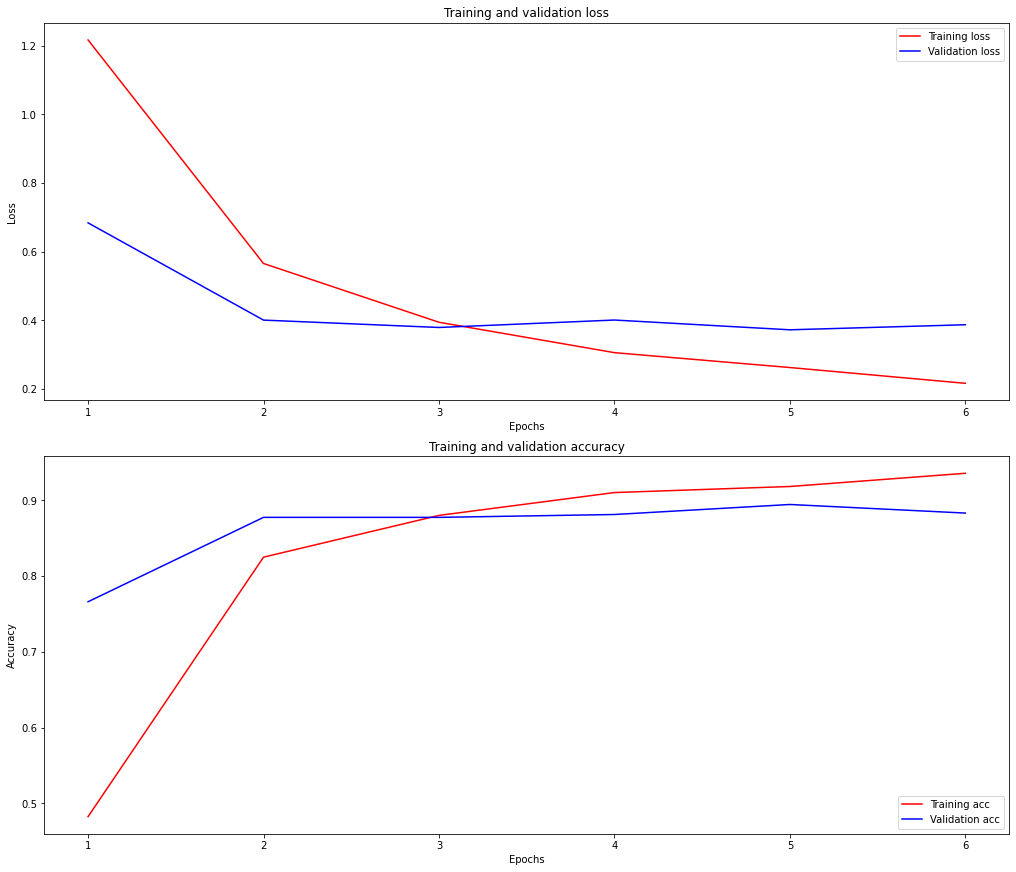

In [9]:
classifier_model_1.plot_training_history_over_time(figsize=(14, 12))


In [11]:
temp_path1 = "saved_models/classification/BERT-CASED-L-12-H-768-A-12"
classifier_model_1.model.save(temp_path1)


### `UNCASED` bert_en_uncased_l_4_h_768_a_12 (RESTRAT BEFORE RUN THIS)

In [5]:
tfhub_handle_preprocess_2 = "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3"
tfhub_handle_encoder_2 = "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-4-h-768-a-12/versions/2"

classifier_model_2 = ClassifierModel(tfhub_handle_preprocess_2, tfhub_handle_encoder_2)
classifier_model_2.compile_model(train_ds=train_ds,
                                 validation_data=val_ds,
                                 epochs=epochs, 
                                 learning_rate=learning_rate, 
                                 optimizer_type=optimizer_type, 
                                 loss=loss, 
                                 metrics=metrics)


In [6]:
classifier_model_2.train()


Model       : https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-4-h-768-a-12/versions/2
Preprocessor: https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3

Epoch 1/6
133/133 [==============================] - 32s 191ms/step - loss: 1.1680 - accuracy: 0.4948 - val_loss: 0.6665 - val_accuracy: 0.8038
Epoch 2/6
133/133 [==============================] - 25s 185ms/step - loss: 0.5593 - accuracy: 0.8183 - val_loss: 0.4411 - val_accuracy: 0.8302
Epoch 3/6
133/133 [==============================] - 25s 187ms/step - loss: 0.4046 - accuracy: 0.8616 - val_loss: 0.4177 - val_accuracy: 0.8491
Epoch 4/6
133/133 [==============================] - 25s 187ms/step - loss: 0.3487 - accuracy: 0.8790 - val_loss: 0.3967 - val_accuracy: 0.8585
Epoch 5/6
133/133 [==============================] - 25s 187ms/step - loss: 0.3112 - accuracy: 0.8978 - val_loss: 0.3951 - val_accuracy: 0.8509
Epoch 6/6
133/13

In [7]:
result = classifier_model_2.evaluate_test(test_ds)
loss, accuracy = result['loss'], result['accuracy']
print()
print(f'Loss     : {loss}')
print(f'Accuracy : {accuracy}')


42/42 [==============================] - 3s 75ms/step - loss: 0.4434 - accuracy: 0.8511

Loss     : 0.4434243142604828
Accuracy : 0.8511278033256531


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Training history over time


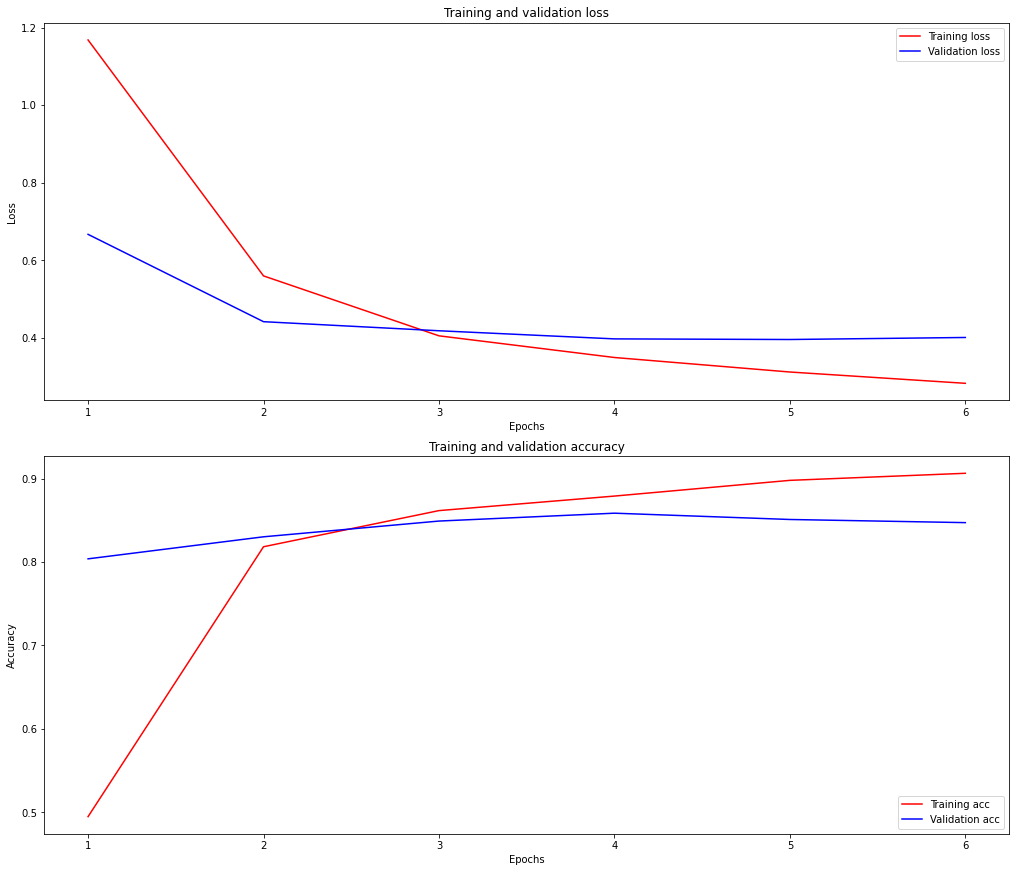

In [8]:
classifier_model_2.plot_training_history_over_time(figsize=(14, 12))


In [9]:
temp_path2 = "saved_models/classification/BERT-UNCASED-L-4-H-768-A-12"
classifier_model_2.model.save(temp_path2)


### Does `cased` and `uncased` smaller version is same in this task?

## End

In [ ]:
raise TypeError("STOP HERE, DON'T, EXECUTE CELL BELOW!")

In [ ]:
# def build_classifier_model(tfhub_preprocess, tfhub_encoder, seq_length=512):
#     # Step 1: Define text input layer
#     text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    
#     # Step 2: Tokenize batches of text inputs
#     bert_preprocess = hub.load(tfhub_preprocess)
#     tokenize = hub.KerasLayer(bert_preprocess.tokenize)
#     tokenized_input = tokenize(text_input)
    
#     # Step 3: Pack input sequences for the Transformer encoder
#     bert_pack_inputs = hub.KerasLayer(
#         bert_preprocess.bert_pack_inputs,
#         arguments=dict(seq_length=seq_length))
#     encoder_inputs = bert_pack_inputs([tokenized_input])
    
#     print(f"input_mask    : {encoder_inputs['input_mask']}")
#     print(f"input_type_ids: {encoder_inputs['input_type_ids']}")
#     print(f"input_word_ids: {encoder_inputs['input_word_ids']}")
#     # Load BERT encoder
#     encoder = hub.KerasLayer(tfhub_encoder, trainable=True, name='BERT_encoder')
    
#     # Pass encoder inputs through BERT encoder
#     outputs = encoder(encoder_inputs)
    
#     # Define classifier layers
#     net = outputs['pooled_output']
#     net = tf.keras.layers.Dropout(0.1)(net)
#     net = tf.keras.layers.Dense(256, activation='relu')(net)  # Additional dense layer
#     net = tf.keras.layers.Dropout(0.1)(net)
#     net = tf.keras.layers.Dense(128, activation='relu')(net)  # Additional dense layer
#     net = tf.keras.layers.Dropout(0.1)(net)
#     net = tf.keras.layers.Dense(64, activation='relu')(net)  # Additional dense layer
#     net = tf.keras.layers.Dropout(0.1)(net)
#     net = tf.keras.layers.Dense(4, activation='softmax', name='classifier')(net)
    
#     # Define and return model
#     return tf.keras.Model(text_input, net)


In [8]:
# classifier_model = build_classifier_model(tfhub_preprocess=tfhub_handle_preprocess, tfhub_encoder=tfhub_handle_encoder)

# epochs = 20
# steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
# num_train_steps = steps_per_epoch * epochs
# optimizer = optimization.create_optimizer(
#     init_lr=1e-5,
#     num_train_steps=num_train_steps,
#     num_warmup_steps=int(0.1*num_train_steps),
#     optimizer_type='adamw')
# # optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# loss = tf.keras.losses.sparse_categorical_crossentropy  # Assuming you have integer labels
# metrics = ['accuracy']

# classifier_model.compile(optimizer=optimizer,
#                          loss=loss,
#                          metrics=metrics)


input_mask    : KerasTensor(type_spec=TensorSpec(shape=(None, 512), dtype=tf.int32, name=None), name='keras_layer_3/PartitionedCall:0', description="created by layer 'keras_layer_3'")
input_type_ids: KerasTensor(type_spec=TensorSpec(shape=(None, 512), dtype=tf.int32, name=None), name='keras_layer_3/PartitionedCall:1', description="created by layer 'keras_layer_3'")
input_word_ids: KerasTensor(type_spec=TensorSpec(shape=(None, 512), dtype=tf.int32, name=None), name='keras_layer_3/PartitionedCall:2', description="created by layer 'keras_layer_3'")


In [12]:
# print(f"Model       : {tfhub_handle_encoder}")
# print(f"Preprocessor: {tfhub_handle_preprocess}\n")
# start = perf_counter()
# history = classifier_model.fit(
#     train_ds, 
#     validation_data=val_ds, 
#     epochs=epochs
#     )
# end = perf_counter()
# print(f"\nTraining time: {end-start:.2f}s")


Model       : https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-cased-l-12-h-768-a-12/versions/4
Preprocessor: https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-cased-preprocess/versions/3


Training time: 0.00s


In [10]:
# classifier_model.predict(tf.constant(["Find all real functions f defined on mathbb R, such that f(f(x)+y) = f(f(x)-y)+4f(x)y ,for all real numbers x,y."]))

1/1 [==============================] - 1s 876ms/step


array([[9.9960226e-01, 8.0112208e-05, 2.3596438e-06, 3.1528284e-04]],
      dtype=float32)

In [11]:
# loss, accuracy = classifier_model.evaluate(test_ds)

# print(f'Loss    : {loss}')
# print(f'Accuracy: {accuracy}')


84/84 [==============================] - 6s 72ms/step - loss: 0.7840 - accuracy: 0.8797
Loss: 0.7840174436569214
Accuracy: 0.8796992301940918


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


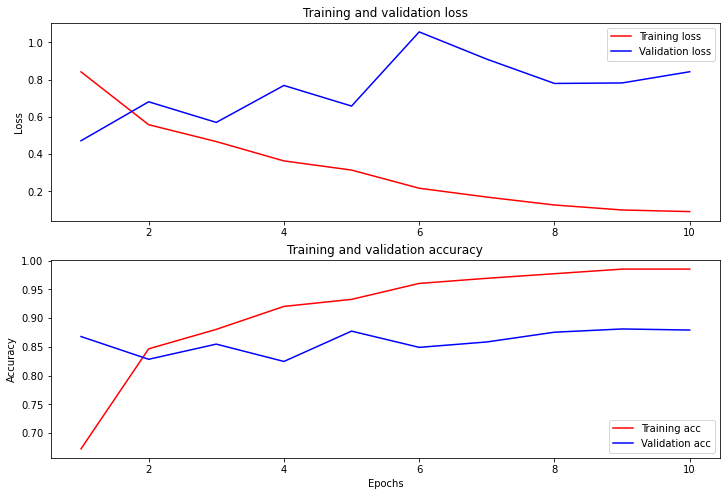

In [12]:
# history_dict = history.history
# print(history_dict.keys())

# acc = history_dict['accuracy']
# val_acc = history_dict['val_accuracy']
# loss = history_dict['loss']
# val_loss = history_dict['val_loss']

# epochs = range(1, len(acc) + 1)
# fig = plt.figure(figsize=(12, 8))
# fig.tight_layout()

# plt.subplot(2, 1, 1)
# # r is for "solid red line"
# plt.plot(epochs, loss, 'r', label='Training loss')
# # b is for "solid blue line"
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# # plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(2, 1, 2)
# plt.plot(epochs, acc, 'r', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')


In [13]:
# classifier_model.save("saved_models/classification/bert-cased-l-12-h-768-a-12")